#CafChem tools for using a simple AI Agent to perform some tool-using tasks using HuggingFace models

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MauricioCafiero/CafChemTeach/blob/main/notebooks/SimpleAgent_CafChem.ipynb)

## This notebook allows you to:
- Load a model from HuggingFace
- Create a simple Agent using Langchain.
- compare against using the unadorned model.

## Requirements:
- This notebook will install several langchain and langgraph libraries and rdkit.
- Runs well on an L4 GPU (using a 7.67 GB model). Will run on the v2-8 TPU runtime, with only slightly slower inference imes. Cannot run on CPU. (Colab runtimes)

### Install langchain libraries

In [2]:
!pip install --upgrade --quiet  langchain-huggingface
!pip install langchain_core --quiet
!pip -q install langchain_community
!pip install -q langgraph
!pip install duckduckgo-search
!pip install -U ddgs -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

### import libraries

In [3]:
import torch
from typing import Annotated, TypedDict
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage, trim_messages, AIMessage, HumanMessage, ToolCall

from langchain_huggingface.llms import HuggingFacePipeline
from langchain_huggingface import ChatHuggingFace
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.runnables import chain
from uuid import uuid4

device = "cuda" if torch.cuda.is_available() else "cpu"

### set up LLM

In [4]:
hf = HuggingFacePipeline.from_model_id(
    model_id="microsoft/Phi-4-mini-instruct",
    task="text-generation",
    pipeline_kwargs = {"max_new_tokens": 200, "temperature": 0.5})

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


## Define functions for Agent

In [7]:
search = DuckDuckGoSearchRun()

@tool
def calculator(query: str) -> str:
  '''
  A simple calculator tool. Input should be a mathematical expression.
  '''
  return eval(query)

tools = [calculator, search]
chat_model = ChatHuggingFace(llm=hf).bind_tools(tools)

In [8]:
class State(TypedDict):
  '''
    Defines the state for the Agent
  '''
  messages: Annotated[list, add_messages]

def first_node(state: State) -> State:
  '''
    The first node of the agent. This node receives the input and asks the LLM
    to determine which is the best tool to use to answer the INITIAL PROMPT.

      Input: the initial prompt from the user.
      Output: the best tool to use to answer the INITIAL PROMPT and a TOOL PROMPT.
  '''

  initial_prompt = state["messages"][-1].content

  prompt = f'For the INITIAL PROMPT given below, determine if one of the tools descibed below \
will be useful in answering the prompt. If so, compose a TOOL PROMPT to feed to that tool. Your \
repsonse should take the form: # tool choice # TOOL PROMPT #. \n \
If the tools cannot be used to answer the INITIAL PROMPT, answer the question on your own. \n\
INITIAL PROMPT: {initial_prompt}.\n \
Tools: \n \
search_tool: this tool can search the web for up-to-date, relevant information \n \
calculator_tool: this tool can perform simple maths.'

  res = chat_model.invoke(prompt)
  #print(res)

  raw_out = str(res).split('<|assistant|>')[1].split('#')
  tool = raw_out[1].strip()
  tool_prompt = raw_out[2].strip()
  answer = f"tool: {tool}, prompt: {tool_prompt}"
  #print(answer)

  return {"messages": answer}


def router_node(state: State) -> State:
  '''
    Receives the tool choice and prompt from the first node and calls the tools.

      Input: the tool choice and prompt from the first node.
      Output: the answer from the tool.
  '''
  raw_input = state["messages"][-1].content

  query_prompt = raw_input.split(',')[1].split(':')[1].strip()
  tool_choice = raw_input.split(',')[0].split(':')[1].strip()

  search_tool_call = None
  calc_tool_call = None

  if 'search' in tool_choice:
    search_tool_call  = ToolCall(
      name='duckduckgo_search', args={'query': query_prompt}, id=uuid4().hex)
  elif 'calculator' in tool_choice:
    calc_tool_call  = ToolCall(
      name='calculator', args={'query': query_prompt}, id=uuid4().hex)
  else:
    raise ValueError("invalid tool chosen")

  tool_list = []
  if search_tool_call is not None:
    tool_list.append(search_tool_call)
  if calc_tool_call is not None:
    tool_list.append(calc_tool_call)

  return {"messages": AIMessage(content="", tool_calls=tool_list)}

def context_node(state: State) -> State:
  '''
    Receives the tool information and feeds it to the model to generate an answer.

      Input: the tool information.
      Output: The prompt for the LLM with tool-provided context.
  '''
  context = state["messages"][-1].content
  state["messages"].pop()

  original_query = state["messages"][0].content

  prompt = f"Use this CONTEXT to answer the ORIGINAL QUESTION: \
CONTEXT: {context} \
ORIGINAL QUESTION: {original_query}"

  return {"messages": HumanMessage(prompt)}

def model_node(state: State) -> State:
  '''
    Receives the prompt for the LLM and generates an answer.

      Input: The prompt for the LLM with tool-provided context.
      Output: The answer from the LLM.
  '''
  res = chat_model.invoke(state["messages"])
  return {"messages": res}

def pretty_print(answer):
  final = str(answer['messages'][-1]).split('<|assistant|>')[-1].split('#')[0].strip("n").strip('\\').strip('n').strip('\\')
  for i in range(0,len(final),100):
    print(final[i:i+100])

def print_short(answer):
  for i in range(0,len(answer),100):
    print(answer[i:i+100])

### Build the graph

In [9]:
builder = StateGraph(State)
builder.add_node("first_node", first_node)
builder.add_node("router_node", router_node)
builder.add_node("tools_node", ToolNode(tools))
builder.add_node("context_node", context_node)
builder.add_node("model_node", model_node)

builder.add_edge(START, "first_node")
builder.add_edge("first_node", "router_node")
builder.add_edge("router_node", "tools_node")
builder.add_edge("tools_node", "context_node")
builder.add_edge("context_node", "model_node")
builder.add_edge("model_node", END)

graph = builder.compile()

## Using the Agent

In [10]:
input = {
    "messages": [
        HumanMessage('When did the movie "Transformers One" come out?')
    ]
}

In [12]:
answer = graph.invoke(input)

str(answer["messages"]).split("<|assistant|>")[-1].split("\'")[0]

'The movie "Transformers One" premiered on September 20, 2024.'

### View Agent Image

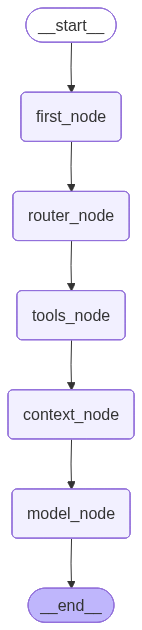

In [103]:
from PIL import Image
import io

img = graph.get_graph().draw_mermaid_png()
image = Image.open(io.BytesIO(img))
image

## Model without tools:

In [15]:
answer = chat_model.invoke('When did the movie "Transformers One" come out?')
str(answer).split("<|assistant|>")[-1].split("\'")[0]

'"Transformers One" is a 2014 animated film produced by Hasbro and released by Paramount Pictures. It is the first film in the Transformers franchise after a hiatus since the 2007 film "Transformers: Revenge of Cybertron." The movie was released on June 13, 2014, in the United States.'